In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

# from xgboost import XGBClassifier
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
import random
random.seed(42)

In [3]:
df = pd.read_csv('./url_updated.csv')

In [4]:
df['label'].value_counts(normalize=True)

0    0.780231
1    0.219769
Name: label, dtype: float64

In [5]:
x = df[['hostname_length','url_length',
       'path_length', 'fd_length', 'spcl_char', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir','path_entropy','subdomain']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(x,y,random_state = 42, stratify = y )

In [6]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

In [7]:
def get_scores_sc(model):
    
    # instantiate model
    model = model()
    
    # fit to scaled data
    model.fit(X_train_sc, y_train)
    
    # make predictions
    preds = model.predict(X_test_sc)

    # print results
    print(f'{model} Training Score: {model.score(X_train_sc, y_train)}')
    print(f'{model} Testing Score: {model.score(X_test_sc, y_test)}')
    print()
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))
    return

In [8]:
def get_scores(model):
    
    # instantiate model
    model = model()
    
    # fit to data
    model.fit(X_train, y_train)
    
    # make predictions
    preds = model.predict(X_test)

    # print results
    print(f'{model} Training Score: {model.score(X_train, y_train)}')
    print(f'{model} Testing Score: {model.score(X_test, y_test)}')
    print()
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))

    return

In [9]:
get_scores(DecisionTreeClassifier)

DecisionTreeClassifier() Training Score: 1.0
DecisionTreeClassifier() Testing Score: 0.9947953422724065

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8845
           1       0.99      0.99      0.99      2491

    accuracy                           0.99     11336
   macro avg       0.99      0.99      0.99     11336
weighted avg       0.99      0.99      0.99     11336

[[8817   28]
 [  31 2460]]


In [10]:
get_scores(BaggingClassifier)

BaggingClassifier() Training Score: 0.999500102919987
BaggingClassifier() Testing Score: 0.9962949894142554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8845
           1       1.00      0.98      0.99      2491

    accuracy                           1.00     11336
   macro avg       1.00      0.99      0.99     11336
weighted avg       1.00      1.00      1.00     11336

[[8841    4]
 [  38 2453]]


In [11]:
get_scores(RandomForestClassifier)

RandomForestClassifier() Training Score: 1.0
RandomForestClassifier() Testing Score: 0.9965596330275229

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8845
           1       1.00      0.99      0.99      2491

    accuracy                           1.00     11336
   macro avg       1.00      0.99      0.99     11336
weighted avg       1.00      1.00      1.00     11336

[[8841    4]
 [  35 2456]]


### Model Optimization

In [73]:
# rfc = RandomForestClassifier()
# rfc_params = {'bootstrap': [True, False],
#                'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#                'max_features': ['auto', 'sqrt'],
#                'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
#                'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600]}

# rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = rfc_params, cv = 3, verbose=2, random_state=42, 
#                                 n_jobs = -1)
# rfc_random.fit(X_train, y_train)
# print(f'Best Parameters: {rfc_random.best_params_}')

Training Score: 0.9995589143411651
Testing Score: 0.9963832039520113

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8845
           1       1.00      0.99      0.99      2491

    accuracy                           1.00     11336
   macro avg       1.00      0.99      0.99     11336
weighted avg       1.00      1.00      1.00     11336

[[8841    4]
 [  37 2454]]


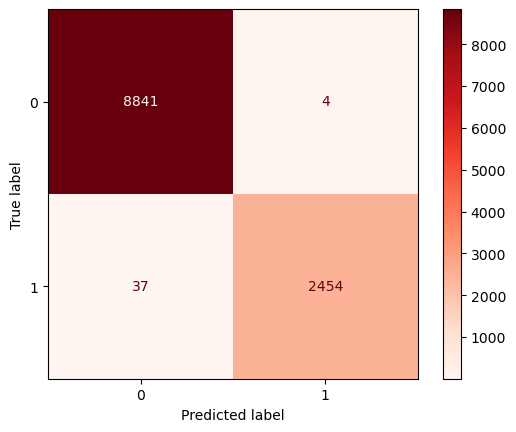

In [12]:
rfc = RandomForestClassifier(n_estimators = 1400, min_samples_split= 5, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 90, 
                             bootstrap= True, n_jobs= -1, random_state=42)
rfc.fit(X_train, y_train)

preds = rfc.predict(X_test)
print(f'Training Score: {rfc.score(X_train, y_train)}')
print(f'Testing Score: {rfc.score(X_test, y_test)}')
print()
print(classification_report(y_test,preds))
print(confusion_matrix(y_test, preds))

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rfc.classes_)
disp.plot(cmap = 'Reds', values_format='')

In [14]:

feature_list = list(x.columns)

importances = list(rfc.feature_importances_)

feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: url_length           Importance: 0.246
Variable: hostname_length      Importance: 0.198
Variable: subdomain            Importance: 0.127
Variable: count-www            Importance: 0.12
Variable: path_length          Importance: 0.079
Variable: count-letters        Importance: 0.073
Variable: spcl_char            Importance: 0.055
Variable: count-digits         Importance: 0.03
Variable: path_entropy         Importance: 0.027
Variable: fd_length            Importance: 0.017
Variable: count_dir            Importance: 0.015
Variable: count-http           Importance: 0.01
Variable: count-https          Importance: 0.003


[None, None, None, None, None, None, None, None, None, None, None, None, None]